In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-07-23 10:18:01,607: INFO: 2549796219: yaml file: config/config.yaml loaded successfully]
[2024-07-23 10:18:01,644: INFO: 2549796219: yaml file: params.yaml loaded successfully]
[2024-07-23 10:18:01,646: INFO: 2549796219: created directory at: artifacts]
[2024-07-23 10:18:01,704: INFO: 2549796219: Training ridge...]
[2024-07-23 10:18:01,746: INFO: 2549796219: ridge - MAE: 0.08730673514782561]
[2024-07-23 10:18:01,748: INFO: 2549796219: Training elasticnet...]
[2024-07-23 10:18:01,770: INFO: 2549796219: elasticnet - MAE: 0.08433974397087915]
[2024-07-23 10:18:01,773: INFO: 2549796219: Training bayesian_ridge...]
[2024-07-23 10:18:01,877: INFO: 2549796219: bayesian_ridge - MAE: 0.09257068055298971]
[2024-07-23 10:18:01,879: INFO: 2549796219: Training huber_regressor...]
[2024-07-23 10:18:13,230: INFO: 2549796219: huber_regressor - MAE: 0.04170007216881275]
[2024-07-23 10:18:13,234: INFO: 2549796219: Training random_forest...]


c:\Users\Farshid Hesami\anaconda3\envs\mlProject\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[2024-07-23 10:18:14,010: INFO: 2549796219: random_forest - MAE: 0.0012074539739559947]
[2024-07-23 10:18:14,012: INFO: 2549796219: Training gradient_boosting...]
[2024-07-23 10:18:14,826: INFO: 2549796219: gradient_boosting - MAE: 1.4441895230546792e-06]
[2024-07-23 10:18:14,828: INFO: 2549796219: Training svr...]
[2024-07-23 10:18:14,839: INFO: 2549796219: svr - MAE: 0.05757374823820343]
[2024-07-23 10:18:14,841: INFO: 2549796219: Training xgboost...]
[2024-07-23 10:18:15,463: INFO: 2549796219: xgboost - MAE: 9.168534974183199e-05]


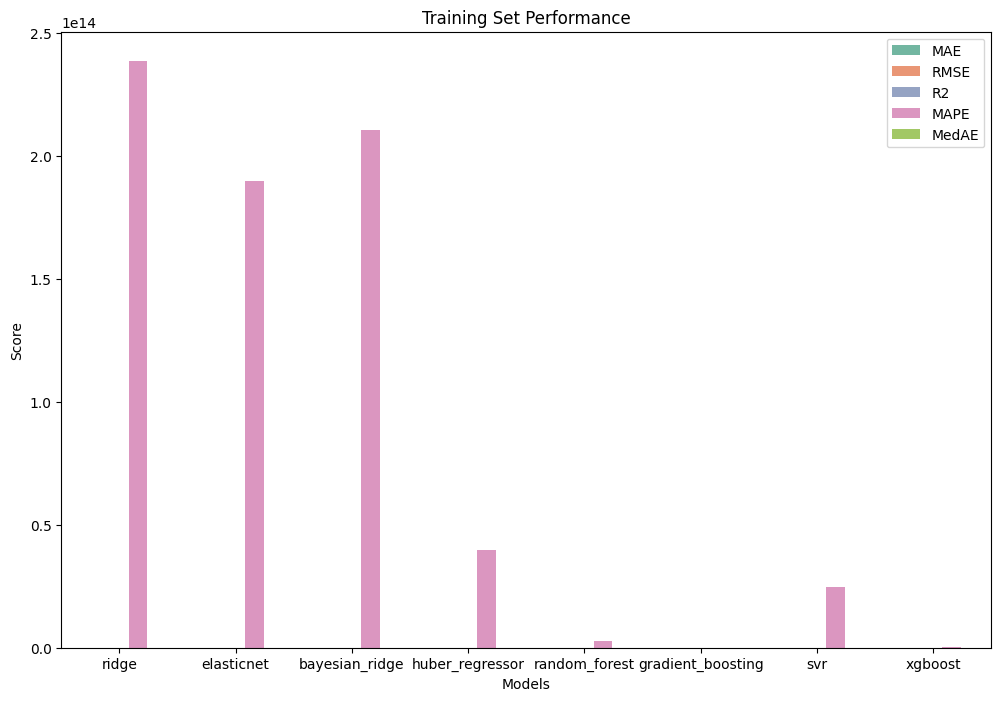


Model Performance:
                         MAE      RMSE        R2          MAPE         MedAE
ridge              0.087307  0.174667  0.396567  2.385968e+14  3.019777e-02
elasticnet         0.084340  0.193323  0.260775  1.899162e+14  1.875637e-02
bayesian_ridge     0.092571  0.207412  0.149105  2.103583e+14  4.963426e-02
huber_regressor    0.041700  0.177853  0.374348  3.972030e+13  3.974083e-06
random_forest      0.001207  0.005471  0.999408  2.645132e+12  0.000000e+00
gradient_boosting  0.000001  0.000003  1.000000  3.252026e+09  7.690603e-07
svr                0.057574  0.224016  0.007415  2.480275e+13  7.308948e-03
xgboost            0.000092  0.000364  0.999997  2.096934e+11  1.057817e-06
[2024-07-23 10:18:16,375: INFO: 2549796219: Tuning ridge...]
[2024-07-23 10:18:22,064: INFO: 2549796219: Best parameters for ridge: {'alpha': 100.0}]
[2024-07-23 10:18:22,066: INFO: 2549796219: Tuning elasticnet...]
[2024-07-23 10:18:22,235: INFO: 2549796219: Best parameters for elasticnet: {'a

c:\Users\Farshid Hesami\anaconda3\envs\mlProject\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[2024-07-23 10:28:29,102: INFO: 2549796219: Best parameters for svr: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}]
[2024-07-23 10:28:29,105: INFO: 2549796219: Tuning random_forest...]
[2024-07-23 10:33:02,059: INFO: 2549796219: Best parameters for random_forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}]
[2024-07-23 10:33:02,062: INFO: 2549796219: Tuning gradient_boosting...]
[2024-07-23 10:34:37,495: INFO: 2549796219: Best parameters for gradient_boosting: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}]
[2024-07-23 10:34:37,499: INFO: 2549796219: Tuning xgboost...]
[2024-07-23 10:34:55,753: INFO: 2549796219: Best parameters for xgboost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}]
[2024-07-23 10:34:55,762: INFO: 2549796219: ridge - Test MAE: 0.07993807812611708, RMSE: 0.15235335990488966, R2: -0.1819255890611131, MAPE: 288485431946467.6, MedAE: 0.03174387330616412]
[2024-07-23 10:34:55,779: INFO: 2549796219: elasti

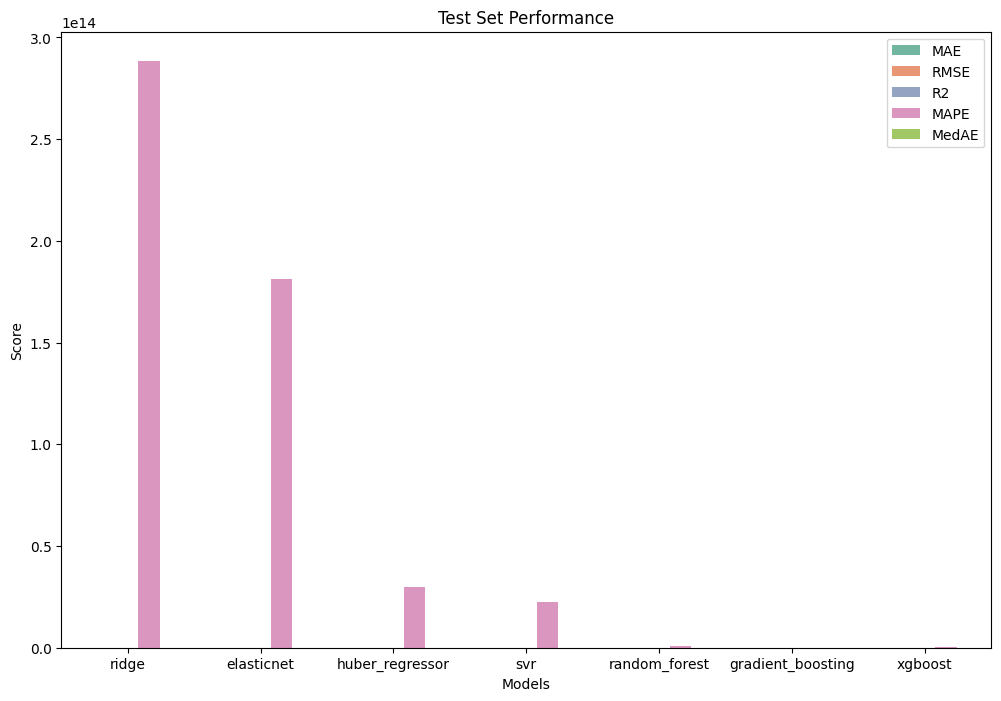


Best Hyperparameters:
 {'ridge': {'alpha': 100.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}, 'elasticnet': {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}, 'huber_regressor': {'alpha': 0.0001, 'epsilon': 1.35, 'fit_intercept': True, 'max_iter': 1000, 'tol': 1e-06, 'warm_start': False}, 'svr': {'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}, 'random_forest': {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,

In [5]:
# Import necessary libraries
import os
from pathlib import Path
import logging
import yaml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error
import joblib
from Dental_Implant_Sandblasting import logger
import matplotlib.pyplot as plt
import seaborn as sns

# Define ModelTrainerConfig dataclass
from dataclasses import dataclass

@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    test_size: float
    random_state: int
    models: dict
    param_grids: dict
    target_column: str
    cv: int
    scoring: str
    poly_features_degree: int
    poly_features_path: Path
    model_path: Path
    imputation_strategy: str
    scaling_method: str
    sa_model_name: str
    cv_model_name: str

# Define ConfigurationManager class
class ConfigurationManager:
    def __init__(self, config_path="config/config.yaml", params_path="params.yaml"):
        self.config = self.read_yaml(config_path)
        self.params = self.read_yaml(params_path)
        self.create_directories([self.config['artifacts_root']])
    
    @staticmethod
    def read_yaml(path_to_yaml: str) -> dict:
        with open(path_to_yaml) as yaml_file:
            content = yaml.safe_load(yaml_file)
        logger.info(f"yaml file: {path_to_yaml} loaded successfully")
        return content

    @staticmethod
    def create_directories(paths: list):
        for path in paths:
            os.makedirs(path, exist_ok=True)
            logger.info(f"created directory at: {path}")
    
    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config['model_trainer']
        params = self.params

        def convert_to_dict(d):
            return {k: list(v) if isinstance(v, (list, tuple)) else v for k, v in d.items()}
        
        model_trainer_config = ModelTrainerConfig(
            root_dir=Path(config['root_dir']),
            train_data_path=Path(config['train_data_path']),
            test_data_path=Path(config['test_data_path']),
            test_size=params['data_transformation']['test_size'],
            random_state=params['data_transformation']['random_state'],
            models=params['model_training']['models'],
            param_grids={key: convert_to_dict(value['param_grid']) for key, value in params['hyperparameter_tuning'].items() if isinstance(value, dict) and 'param_grid' in value},
            target_column=params['model_training']['target_column'],
            cv=params['hyperparameter_tuning']['cv'],
            scoring=params['hyperparameter_tuning']['scoring'],
            poly_features_degree=params['data_transformation']['polynomial_features_degree'],
            poly_features_path=Path(config['poly_features_path']),
            model_path=Path(config['model_path']),
            imputation_strategy=params['data_preprocessing']['imputation_strategy'],
            scaling_method=params['data_transformation']['scaling_method'],
            sa_model_name=config['sa_model_name'],
            cv_model_name=config['cv_model_name']
        )
        return model_trainer_config

# Define ModelTrainer class
class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config
        self.poly = None  # Initialize the poly attribute
    
    def load_data(self):
        try:
            train_data = pd.read_csv(self.config.train_data_path)
            test_data = pd.read_csv(self.config.test_data_path)
            
            X_train = train_data.drop(columns=[self.config.target_column])
            y_train = train_data[self.config.target_column]
            
            X_test = test_data.drop(columns=[self.config.target_column])
            y_test = test_data[self.config.target_column]
            
            return X_train, y_train, X_test, y_test
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            raise e
    
    def preprocess_data(self, X_train, y_train, X_test, y_test):
        try:
            # Imputation
            imputer = SimpleImputer(strategy=self.config.imputation_strategy)
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)

            y_imputer = SimpleImputer(strategy="most_frequent")
            y_train = y_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
            y_test = y_imputer.transform(y_test.values.reshape(-1, 1)).ravel()

            # Create polynomial features
            poly = PolynomialFeatures(degree=self.config.poly_features_degree)
            self.poly = poly  # Assign the poly attribute
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)

            # Ensure the directory exists
            poly_features_path = self.config.poly_features_path
            poly_features_path.parent.mkdir(parents=True, exist_ok=True)

            # Save polynomial features for later use
            joblib.dump(poly, poly_features_path)

            # Scaling
            if self.config.scaling_method == "StandardScaler":
                scaler = StandardScaler()
            else:
                raise ValueError(f"Unknown scaling method: {self.config.scaling_method}")
            
            X_train_scaled = scaler.fit_transform(X_train_poly)
            X_test_scaled = scaler.transform(X_test_poly)
            
            return X_train_scaled, y_train, X_test_scaled, y_test
        except PermissionError as e:
            logger.error(f"Permission denied: {e}")
            raise e
        except Exception as e:
            logger.error(f"Error preprocessing data: {e}")
            raise e

    def evaluate_models(self, X_train, y_train):
        try:
            models = self.config.models
            performance_metrics = {}

            for model_name, model_params in models.items():
                logger.info(f"Training {model_name}...")
                if model_name == "ridge":
                    model = Ridge(**model_params)
                elif model_name == "elasticnet":
                    model = ElasticNet(**model_params)
                elif model_name == "bayesian_ridge":
                    model = BayesianRidge(**model_params)
                elif model_name == "huber_regressor":
                    model = HuberRegressor(**model_params)
                elif model_name == "random_forest":
                    model = RandomForestRegressor(**model_params)
                elif model_name == "gradient_boosting":
                    model = GradientBoostingRegressor(**model_params)
                elif model_name == "svr":
                    model = SVR(**model_params)
                elif model_name == "xgboost":
                    model = XGBRegressor(**model_params)
                else:
                    raise ValueError(f"Unknown model: {model_name}")

                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)

                mae = mean_absolute_error(y_train, y_pred_train)
                rmse = mean_squared_error(y_train, y_pred_train, squared=False)
                r2 = r2_score(y_train, y_pred_train)
                mape = mean_absolute_percentage_error(y_train, y_pred_train)
                medae = median_absolute_error(y_train, y_pred_train)

                performance_metrics[model_name] = {
                    "MAE": mae,
                    "RMSE": rmse,
                    "R2": r2,
                    "MAPE": mape,
                    "MedAE": medae
                }
                logger.info(f"{model_name} - MAE: {mae}")

            # Visualization: Performance Metrics
            self.visualize_performance(performance_metrics, test=False)
            return performance_metrics
        except Exception as e:
            logger.error(f"Error evaluating models: {e}")
            raise e
    
    def hyperparameter_tuning(self, X_train, y_train):
        try:
            best_models = {}

            for model_name, param_grid in self.config.param_grids.items():
                if model_name == "ridge":
                    model = Ridge()
                elif model_name == "elasticnet":
                    model = ElasticNet()
                elif model_name == "huber_regressor":
                    model = HuberRegressor()
                elif model_name == "svr":
                    model = SVR()
                elif model_name == "random_forest":
                    model = RandomForestRegressor()
                elif model_name == "gradient_boosting":
                    model = GradientBoostingRegressor()
                elif model_name == "xgboost":
                    model = XGBRegressor()
                else:
                    raise ValueError(f"Unknown model: {model_name}")

                grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=self.config.cv, scoring=self.config.scoring, n_jobs=-1)
                logger.info(f"Tuning {model_name}...")
                grid_search.fit(X_train, y_train)
                best_models[model_name] = grid_search.best_estimator_
                logger.info(f"Best parameters for {model_name}: {grid_search.best_params_}")

            return best_models
        except Exception as e:
            logger.error(f"Error during hyperparameter tuning: {e}")
            raise e
    
    def evaluate_best_models(self, best_models, X_test, y_test):
        try:
            performance_metrics = {}

            for model_name, model in best_models.items():
                y_pred_test = model.predict(X_test)

                mae = mean_absolute_error(y_test, y_pred_test)
                rmse = mean_squared_error(y_test, y_pred_test, squared=False)
                r2 = r2_score(y_test, y_pred_test)
                mape = mean_absolute_percentage_error(y_test, y_pred_test)
                medae = median_absolute_error(y_test, y_pred_test)

                performance_metrics[model_name] = {
                    "MAE": mae,
                    "RMSE": rmse,
                    "R2": r2,
                    "MAPE": mape,
                    "MedAE": medae
                }
                logger.info(f"{model_name} - Test MAE: {mae}, RMSE: {rmse}, R2: {r2}, MAPE: {mape}, MedAE: {medae}")

            # Visualization: Best Model Performance
            self.visualize_performance(performance_metrics, test=True)
            return performance_metrics
        except Exception as e:
            logger.error(f"Error evaluating best models: {e}")
            raise e
    
    def save_models(self, best_models):
        try:
            for model_name, model in best_models.items():
                model_save_path = self.config.model_path / f"{model_name}.joblib"
                model_save_path.parent.mkdir(parents=True, exist_ok=True)
                joblib.dump(model, model_save_path)
                logger.info(f"Saved {model_name} model at: {model_save_path}")

            # Save the best models for 'sa' and 'cv' with the expected filenames
            best_model_sa = best_models.get(self.config.sa_model_name)
            best_model_cv = best_models.get(self.config.cv_model_name)

            if best_model_sa:
                joblib.dump(best_model_sa, self.config.model_path / 'best_model_sa.joblib')
                logger.info("Saved best model for Surface Roughness (Sa) at: artifacts/model_trainer/models/best_model_sa.joblib")
            
            if best_model_cv:
                joblib.dump(best_model_cv, self.config.model_path / 'best_model_cv.joblib')
                logger.info("Saved best model for Cell Viability (CV) at: artifacts/model_trainer/models/best_model_cv.joblib")
            
            # Save polynomial features
            joblib.dump(self.poly, self.config.poly_features_path)
            logger.info("Saved polynomial features at: artifacts/model_trainer/poly_features.joblib")

        except Exception as e:
            logger.error(f"Error saving model {model_name}: {e}")
            raise e
    
    def visualize_performance(self, performance_metrics, test=False):
        try:
            metric_df = pd.DataFrame(performance_metrics).T
            metric_df = metric_df[['MAE', 'RMSE', 'R2', 'MAPE', 'MedAE']]

            if test:
                title = 'Test Set Performance'
            else:
                title = 'Training Set Performance'

            plt.figure(figsize=(12, 8))
            sns.barplot(data=metric_df.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable', palette="Set2")
            plt.title(title)
            plt.xlabel('Models')
            plt.ylabel('Score')
            plt.legend(loc='upper right')
            plt.show()
        except Exception as e:
            logger.error(f"Error visualizing performance: {e}")
            raise e

    def execute(self):
        try:
            X_train, y_train, X_test, y_test = self.load_data()
            X_train, y_train, X_test, y_test = self.preprocess_data(X_train, y_train, X_test, y_test)
            model_performance = self.evaluate_models(X_train, y_train)
            performance_df = pd.DataFrame(model_performance).T
            print("\nModel Performance:\n", performance_df)

            best_models = self.hyperparameter_tuning(X_train, y_train)
            performance_metrics = self.evaluate_best_models(best_models, X_test, y_test)

            best_hyperparameters = {model_name: model.get_params() for model_name, model in best_models.items()}
            print("\nBest Hyperparameters:\n", best_hyperparameters)
            print("\nPerformance Metrics:\n", performance_metrics)

            self.save_models(best_models)
        except Exception as e:
            logger.exception(e)
            raise e

# Pipeline execution
try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer = ModelTrainer(config=model_trainer_config)
    model_trainer.execute()
except Exception as e:
    logger.exception(e)